# 🚗🚙 Car Make Verification
Project for *Neural Networks and Deep Learning*, A.Y. 2024/2025, by Lorenzo Martinelli (2125031), Arina Ponomareva (2106897), and Laura Schulze (2122311).

This notebook constitutes the second half of our project, where we aim to perform car make verification using the CompCars dataset. Again, we aim to tackle this task with snapshot ensembling. The notebook is structured into 3 parts: **Data preprocessing**, **Model training**, and **Testing and Results**.

Library imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn import functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import efficientnet_b0

import os
import cv2
import random
import shutil
from tqdm import tqdm
import  csv
from collections import Counter
from sklearn.model_selection import train_test_split
from PIL import Image
import math
import copy
np.random.seed(13)

Checking if the GPU is available:

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda


## Data preprocessing

For the verification task, we want to experiment with a **siamese neural network** architecture. Since we now need to compare image pairs, we have to introduce a new training and validation set. The CompCars dataset already comes with several lists of image pairs for verification tasks, sorted by difficulty. These sets are perfectly balanced between positive and negative pairs. Unfortunately for us, the authors did the verification task by car model instead of car make, so we have to adjust some of the positive/negative pairs, which will slightly disturb that balance.

In [3]:
data_path = "/mnt/data/"
# check data accessibility
if os.path.exists(data_path):
    print( "Data path is accessible!")
    print("Files in data directory:", os.listdir(data_path))
else:
    print(" Data path NOT found! Check your dataset mount.")

Data path is accessible!
Files in data directory: ['image', 'label', 'misc', 'part', 'train_test_split']


To have more data to train on, we merge the `easy` and `medium` datasets. This also introduces some more complexity for our network to learn.

In [4]:
image_base_path = "/mnt/data/image"
path1 = "/mnt/data/train_test_split/verification/verification_pairs_medium.txt"
pairs = []
with open(path1, "r") as f:
    for line in f:
        img1, img2, label = line.strip().split()
        img1_path = os.path.join(image_base_path, img1)
        img2_path = os.path.join(image_base_path, img2)
        label = int(label)
        pairs.append((img1_path, img2_path, label))

path2 = "/mnt/data/train_test_split/verification/verification_pairs_easy.txt"
with open(path2, "r") as f:
  for line in f:
    img1, img2, label = line.strip().split()
    img1_path = os.path.join(image_base_path, img1)
    img2_path = os.path.join(image_base_path, img2)
    label = int(label)
    pairs.append((img1_path, img2_path, label))

print(f"Total Pairs: {len(pairs)}")

Total Pairs: 40000


Now, we need to find the pairs that have different models, but the same make, and relabel them as positive (label=1) instead of negative (label=0).

In [5]:
modified_pairs = []
for img1, img2, label in pairs:
    category1 = img1.split("/")[-4]
    category2 = img2.split("/")[-4]

    # Redefine positive pairs: only match on the make
    new_label = 1 if category1 == category2 else 0

    modified_pairs.append((img1, img2, new_label))

label_counts2 = Counter(label for _, _, label in modified_pairs)
print(f"Positive Pairs (same make): {label_counts2[1]}")
print(f"Negative Pairs (different make): {label_counts2[0]}")

Positive Pairs (same make): 20256
Negative Pairs (different make): 19744


After relabelling the pairs, we are left with a slight imbalance, as slightly more than 50% of the samples (50.64%) are positive pairs. Given how small this imbalance is, it will likely not have a strong effect.

We continue by performing the train-validation split, and furthermore define some image transformations for data augmentation:

In [6]:
# Train-validation-test split
train_pairs, oth_pairs = train_test_split(modified_pairs, test_size = 0.2,
                                          random_state = 13)
val_pairs, test_pairs = train_test_split(oth_pairs, test_size = 0.5,
                                         random_state = 13)

# Define transformations
train_trans   = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 15, translate = (.2, .2)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

val_test_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Used in some tests; no augmentation
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Define a class for the dataset
class SiameseDataset(Dataset):
  def __init__(self, pairs, transforms = None):
    self.pairs = pairs
    self.transforms = transforms

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    img1_path, img2_path, label = self.pairs[idx]
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    if transforms is not None:
      img1 = self.transforms(img1)
      img2 = self.transforms(img2)

    return img1, img2, label

# Get the training-validation-test datasets
train_dataset = SiameseDataset(train_pairs, train_trans)
val_dataset   = SiameseDataset(val_pairs, val_test_trans)
test_dataset  = SiameseDataset(test_pairs, val_test_trans)

Defining the data loaders and checking the train-validation-test split:

In [7]:
BATCH_SIZE = 512

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE)

print(f"Train samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")
image1, image2, labels = next(iter(train_loader))
print(f"Images shape: {image1.shape}, {image2.shape}")

Train samples: 32000 | Validation samples: 4000 | Test samples: 4000
Images shape: torch.Size([512, 3, 224, 224]), torch.Size([512, 3, 224, 224])


In [8]:
# Print one example of the training set to see if it worked fine:
print(image1[0])
print(image2[0])
print(labels[0])

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -1.8268, -1.7754, -1.7925],
         [-2.1179, -2.1179, -2.1179,  ..., -1.8782, -1.9124, -1.8782],
         [-2.1179, -2.1179, -2.1179,  ..., -1.4329, -1.4500, -1.3644]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -1.6155, -1.5630, -1.5805],
         [-2.0357, -2.0357, -2.0357,  ..., -1.7031, -1.7031, -1.6856],
         [-2.0357, -2.0357, -2.0357,  ..., -1.2654, -1.2654, -1.1779]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Now that our data is ready, we can start to build our model.

## Model training
 We are going to use a similar model as the one we introduced in the other task, that is **EfficientNet-B0**. However, unlike with the previous task, here we want to run a slightly different training loop, one based on pairs instead of single images. Still, our initial training stages remain the same compared to the other notebook.

Defining the EfficientNet-B0 backbone:

In [9]:
model_backbone = efficientnet_b0(weights = True)
model_backbone = nn.Sequential(*list(model_backbone.children())[:-1])

/home/ubuntu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare to train only the last layers:

In [10]:
# Freeze stages 1 through 5
# First, freeze ALL stages
for param in model_backbone.parameters():
  param.requires_grad = False       # Block the SGD for all parameters

for layer in model_backbone[0][-3:]:
  for param in layer.parameters():
    param.requires_grad = True       # Unlock the SGD for the last two blocks of the network

# Transfer the model to the device (GPU, if available)
model_backbone.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
    

Define the `SiameseNetwork` class, which handles 2 image inputs at the same time, as well as the contrastive loss:

In [11]:
class SiameseNetwork(nn.Module):
  def __init__(self, backbone = model_backbone):
    super().__init__()
    self.backbone = backbone
    self.fc = nn.Linear(1280, 512)
    self.dropout = nn.Dropout(0.3)

  def forward_one(self, x):
      x = self.backbone(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)
      x = self.dropout(x)
      return x

  def forward(self, x1, x2):
    x1 = self.forward_one(x1)
    x2 = self.forward_one(x2)
    return x1, x2


class ContrastiveLoss(nn.Module):
    def __init__(self, margin = 1.0):
      super().__init__()
      self.margin = margin

    def forward(self, out1, out2, label):
      distance = F.cosine_similarity(out1, out2, dim = 1, eps = 1e-8)
      loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                        (label) * torch.pow(torch.clamp(self.margin - distance,
                                                        min=0.0), 2))

      return loss


# Used in some experimentations
class ContrastiveLoss_cos_dist(nn.Module):
    def __init__(self, margin = 2.0):
      super().__init__()
      self.margin = margin

    def forward(self, out1, out2, label):
      distance = 1 - F.cosine_similarity(out1, out2, dim = 1, eps = 1e-8) # use cosine distance
      loss = torch.mean((label) * torch.pow(distance, 2) +     # positive pairs
                        (1-label) * torch.pow(torch.clamp(self.margin - distance,  
                                                        min=0.0), 2))     # negative pairs

      return loss

We define 2 different contrastive loss functions, one based on the cosine similarity, and one based on the cosine distance (1-cosine similarity). Over the course of our analysis, we trained a model with both and compared the results.

As in the other notebook, we set up a cyclic learning rate with a shifted cosine function:

In [12]:
# Define the number of epochs and snapshots
num_epochs = 30
num_snapshots = np.ceil(num_epochs / 5)

# Choose only the parameters that require a gradient
trainable_params = filter(lambda p: p.requires_grad, model_backbone.parameters())

# Define the loss: Contrastive loss
loss_fn = ContrastiveLoss()

# Utilize the LR seen in the paper of Huang, Li et al. (2016)
class ShiftedCosineLR(lr_scheduler.LambdaLR):
  def __init__(self, optimizer, init_lr, T, M):
    self.init_lr = init_lr
    self.T = T
    self.M = M
    self.T_m = math.ceil(T/M)

    super().__init__(optimizer, self.lr_lambda)

  def lr_lambda(self, epoch):
    epoch_tensor = torch.tensor(math.pi * ((epoch % self.T_m) / self.T_m))
    return 0.5 * self.init_lr * (1 + torch.cos(epoch_tensor))

# Set the best learning rate
# (either use results from  previous notebook or perform a new search?)
best_lr = 0.1

# Choose the optimizer: Adam
optimizer = optim.Adam(trainable_params, lr = best_lr)

# Scheduler for the learning rate
scheduler = ShiftedCosineLR(optimizer, init_lr = best_lr, T = num_epochs,
                            M = num_snapshots)

model = SiameseNetwork()
model = model.to(device)

Now, we can start the training loop. We once again log the training and validation loss throughout the training process.

In [16]:
# prepare csv file to log the losses
log_file_path = "/home/ubuntu/training_log_verification.csv"
if not os.path.exists(log_file_path):
    with open(log_file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss"])

torch.cuda.empty_cache()      # Free unused memory   

### Start training loop ###

# Lists to keep track of losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  print(f"Epoch: {epoch + 1}")
  epoch_train_loss = 0
  iterator = tqdm(train_loader)

  # Training phase
  for images1, images2, labels in iterator:
    images1, images2 = images1.to(device), images2.to(device)
    labels = labels.to(device)

    outputs1, outputs2 = model(images1, images2)

    loss = loss_fn(outputs1, outputs2, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_train_loss += loss.item()

    iterator.set_description(f"Train Loss: {loss.detach().cpu().numpy()}")

  epoch_train_loss /= len(train_loader)
  train_losses.append(epoch_train_loss)

  # Validation phase
  model.eval()
  with torch.no_grad():
    val_loss = 0
    iterator = tqdm(val_loader)
      
    for images1, images2, labels in iterator:
      images1, images2 = images1.to(device), images2.to(device)
      labels = labels.to(device)

      pred1, pred2 = model(images1, images2)
      loss = loss_fn(pred1, pred2, labels)
      val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss}")

    # Next step in the scheduler
    scheduler.step()
   
  # write losses to log file
  with open(log_file_path, 'a', newline='') as f:
      writer  = csv.writer(f)
      writer.writerow([epoch +  1, epoch_train_loss, val_loss])

  # save snapshot every 5 epochs
  if (epoch + 1) % 5 == 0:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch + 1,
        'train_loss': epoch_train_loss,
        'val_loss': val_loss
    }

    checkpoint_path = f'/home/ubuntu/checkpoint_verification_{epoch +1}.pth'
    torch.save(checkpoint, f'/home/ubuntu/checkpoint_siamese_{epoch + 1}.pth')

    print(f"Snapshot saved at epoch {epoch+1}")

Epoch: 1


/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Train Loss: 0.3152816593647003:   3%|▍           | 2/63 [00:17<08:59,  8.84s/it]


KeyboardInterrupt: 

Check that the losses were logged correctly in the csv file:

In [13]:
log_file_path = '/home/ubuntu/training_log_verification.csv'
df = pd.read_csv(log_file_path)
training_loss = np.array(df['training_loss'])
validation_loss = np.array(df['validation_loss'])
print(df)

    epoch  training_loss  validation_loss
0       1       0.183168         0.151709
1       2       0.152328         0.122329
2       3       0.138855         0.118086
3       4       0.129739         0.115284
4       5       0.122192         0.104997
5       6       0.132746         0.119618
6       7       0.126927         0.109523
7       8       0.120043         0.099167
8       9       0.112691         0.094139
9      10       0.107619         0.090894
10     11       0.117316         0.109385
11     12       0.115883         0.099445
12     13       0.110450         0.086523
13     14       0.103536         0.085093
14     15       0.099601         0.082871
15     16       0.109489         0.093496
16     17       0.108102         0.091310
17     18       0.103102         0.085687
18     19       0.098126         0.081800
19     20       0.093824         0.080175
20     21       0.103330         0.085992
21     22       0.102921         0.085545
22     23       0.097990         0

To check how the model training went, we plot the Training and Validation loss curves:

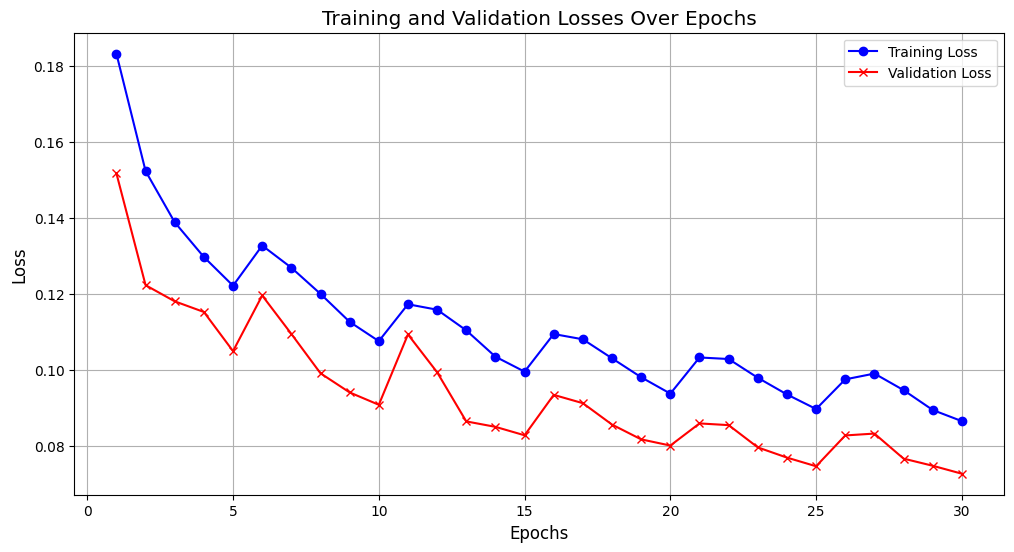

In [14]:
plt.figure(figsize=(12, 6))
epochs_logged = np.arange(1, 31, 1)

plt.plot(epochs_logged, training_loss, label="Training Loss",
         color="Blue", linestyle="-", marker="o")
plt.plot(epochs_logged, validation_loss, label="Validation Loss",
         color="Red", linestyle="-", marker="x")

plt.xlabel("Epochs", fontsize="large")
plt.ylabel("Loss", fontsize="large")
plt.title("Training and Validation Losses Over Epochs", fontsize="x-large")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Testing and Results
Now that we have successfully trained our Siamese Network and extracted snapshots, it is time to build ensembles and test their performance on the test set.

First, we load the saved snapshots:

In [15]:
num_snapshots = 6
snapshot_models = []

for i in range(num_snapshots):
    model = SiameseNetwork()
    checkpoint = torch.load(f"cos_dist_checkpoint_siamese_{(i+1)*5}.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    snapshot_models.append(model)

print(f"Loaded {len(snapshot_models)} snapshot models.")

Loaded 6 snapshot models.


Define a function to handle ensemble prediction through averaging:

In [16]:
def ensemble_predictions(models, image1, image2):
    """
    Get the average similarity score from multiple models.
    """
    with torch.no_grad():
        predictions = []

        for model in models:
            output1, output2 = model(image1, image2)
            similarity = torch.nn.functional.cosine_similarity(output1, output2, dim=-1)
            predictions.append(similarity.cpu().numpy())

        # Convert list to numpy array and compute the mean
        avg_similarity = np.mean(predictions, axis=0)

    return avg_similarity

First, let's check the performance of the full ensemble:

In [17]:
correct = 0
total = 0
threshold = 0.5
all_preds = []
all_labels = []

for images1, images2, labels in test_loader:
    images1, images2, labels = images1.to(device), images2.to(device), labels.cpu().numpy()

    avg_similarity = ensemble_predictions(snapshot_models, images1, images2)

    # Convert similarity scores into binary predictions
    predictions = (avg_similarity > threshold).astype(int)

    correct += (predictions == labels).sum()
    total += labels.shape[0]

    all_preds.extend(avg_similarity)
    all_labels.extend(labels)

# Compute final accuracy
accuracy = correct / total
print(f"Ensemble Accuracy: {accuracy:.4f}")

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Ensemble Accuracy: 0.8340


Plotting the confusion matrix:

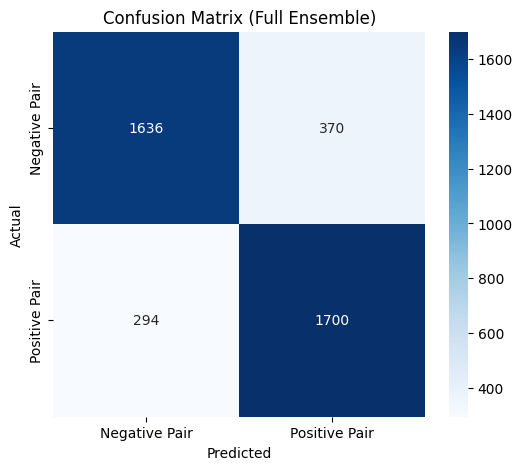

In [18]:
from sklearn.metrics import confusion_matrix

# Convert similarity scores to binary predictions
threshold = 0.5
binary_preds = (all_preds > threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(all_labels, binary_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative Pair', 'Positive Pair'],
            yticklabels=['Negative Pair', 'Positive Pair'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Full Ensemble)')
plt.show()

Plotting the ROC curve:

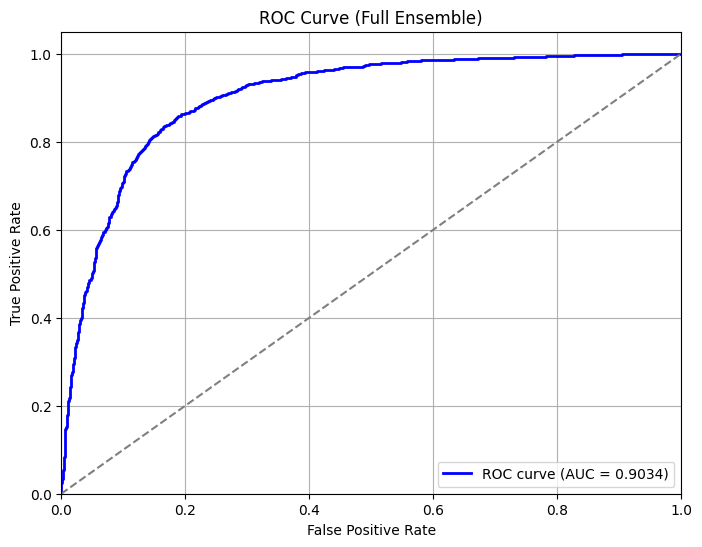

In [19]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Full Ensemble)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In the following, we compare the results from models that were obtained with slightly different training and ensembling modalities, such as:
- using no data augmentation
- using contrastive loss with cosine distance instead of cosine similarity
- using only the final snapshot instead of building an ensemble

In [21]:
# Test with the final snapshot, as well as different techniques

def ensemble_predictions_cos_dist(models, image1, image2):
    """
    Get the average similarity score from multiple models (cosine distance).
    """
    with torch.no_grad():
        predictions = []

        for model in models:
            output1, output2 = model(image1, image2)
            similarity = 1 - torch.nn.functional.cosine_similarity(output1, output2, dim=-1)
            predictions.append(similarity.cpu().numpy())

        # Convert list to numpy array and compute the mean
        avg_similarity = np.mean(predictions, axis=0)

    return avg_similarity

# Final snapshot only
model_final = SiameseNetwork()
checkpoint = torch.load(f"checkpoint_siamese_30.pth")
model_final.load_state_dict(checkpoint['model_state_dict'])
model_final.to(device)
model_final.eval()

# No data augmentation and cosine distance
ensemble_no_aug   = []
ensemble_cos_dist = []
for i in range(num_snapshots):
    # No augmentation
    model_no_aug = SiameseNetwork()
    checkpoint = torch.load(f"test1/checkpoint_siamese_{(i+1)*5}.pth")
    model_no_aug.load_state_dict(checkpoint['model_state_dict'])
    model_no_aug.to(device)
    model_no_aug.eval()
    ensemble_no_aug.append(model_no_aug)

    # Cosine distance
    model_cos_dist = SiameseNetwork()
    checkpoint = torch.load(f"cos_dist_checkpoint_siamese_{(i+1)*5}.pth")
    model_cos_dist.load_state_dict(checkpoint['model_state_dict'])
    model_cos_dist.to(device)
    model_cos_dist.eval()
    ensemble_cos_dist.append(model_cos_dist)


correct_final = 0
correct_no_aug = 0
correct_cos_dist = 0
threshold_cos_dist = 1
all_preds_final = []
all_preds_no_aug = []
all_preds_cos_dist = []


for images1, images2, labels in test_loader:
    images1, images2, labels = images1.to(device), images2.to(device), labels.cpu().numpy()

    avg_similarity_final = ensemble_predictions([model_final], images1, images2)
    avg_similarity_no_aug = ensemble_predictions(ensemble_no_aug, images1, images2)
    avg_similarity_cos_dist = ensemble_predictions_cos_dist(ensemble_cos_dist, images1, images2)

    # Convert similarity scores into binary predictions
    predictions_final = (avg_similarity_final > threshold).astype(int)
    predictions_no_aug = (avg_similarity_no_aug > threshold).astype(int)
    predictions_cos_dist = (avg_similarity_cos_dist < threshold_cos_dist).astype(int)

    correct_final += (predictions_final == labels).sum()
    correct_no_aug += (predictions_no_aug == labels).sum()
    correct_cos_dist += (predictions_cos_dist == labels).sum()

    all_preds_final.extend(avg_similarity_final)
    all_preds_no_aug.extend(avg_similarity_no_aug)
    all_preds_cos_dist.extend(avg_similarity_cos_dist)

# Compute final accuracy
accuracy_final = correct_final / total
accuracy_no_aug = correct_no_aug / total
accuracy_cos_dist = correct_cos_dist / total
print(f"Ensemble Accuracy (final snapshot only): {accuracy_final:.4f}")
print(f"Ensemble Accuracy (no data augmentation): {accuracy_no_aug:.4f}")
print(f"Ensemble Accuracy (cosine distance): {accuracy_cos_dist:.4f}")

all_preds_final = np.array(all_preds_final)
all_preds_no_aug = np.array(all_preds_no_aug)
all_preds_cos_dist = np.array(all_preds_cos_dist)

Ensemble Accuracy (final snapshot only): 0.7993
Ensemble Accuracy (no data augmentation): 0.7963
Ensemble Accuracy (cosine distance): 0.7438


Plotting the ROC curves:

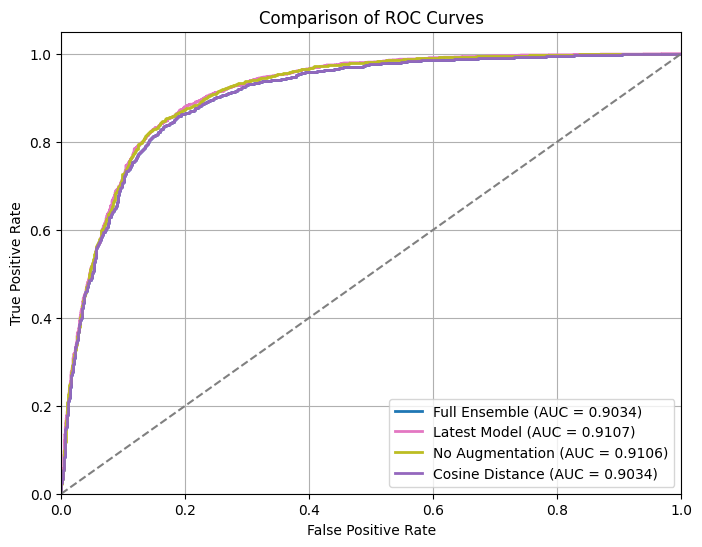

In [24]:
fpr_final, tpr_final, _ = roc_curve(all_labels, all_preds_final)
fpr_no_aug, tpr_no_aug, _ = roc_curve(all_labels, all_preds_no_aug)
fpr_cos_dist, tpr_cos_dist, _ = roc_curve(all_labels, 1 - all_preds_cos_dist)    # Flip for consistency

# Compute AUC scores
auc_final = auc(fpr_final, tpr_final)
auc_no_aug = auc(fpr_no_aug, tpr_no_aug)
auc_cos_dist = auc(fpr_cos_dist, tpr_cos_dist)


# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = f'Full Ensemble (AUC = {roc_auc:.4f})')
plt.plot(fpr_final, tpr_final, color = 'tab:pink', lw = 2, label = f'Latest Model (AUC = {auc_final:.4f})')
plt.plot(fpr_no_aug, tpr_no_aug, color = 'tab:olive', lw = 2, label = f'No Augmentation (AUC = {auc_no_aug:.4f})')
plt.plot(fpr_cos_dist, tpr_cos_dist, color = 'tab:purple', lw = 2, label = f'Cosine Distance (AUC = {auc_cos_dist:.4f})')

# Random chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Plotting the confusion matrices:

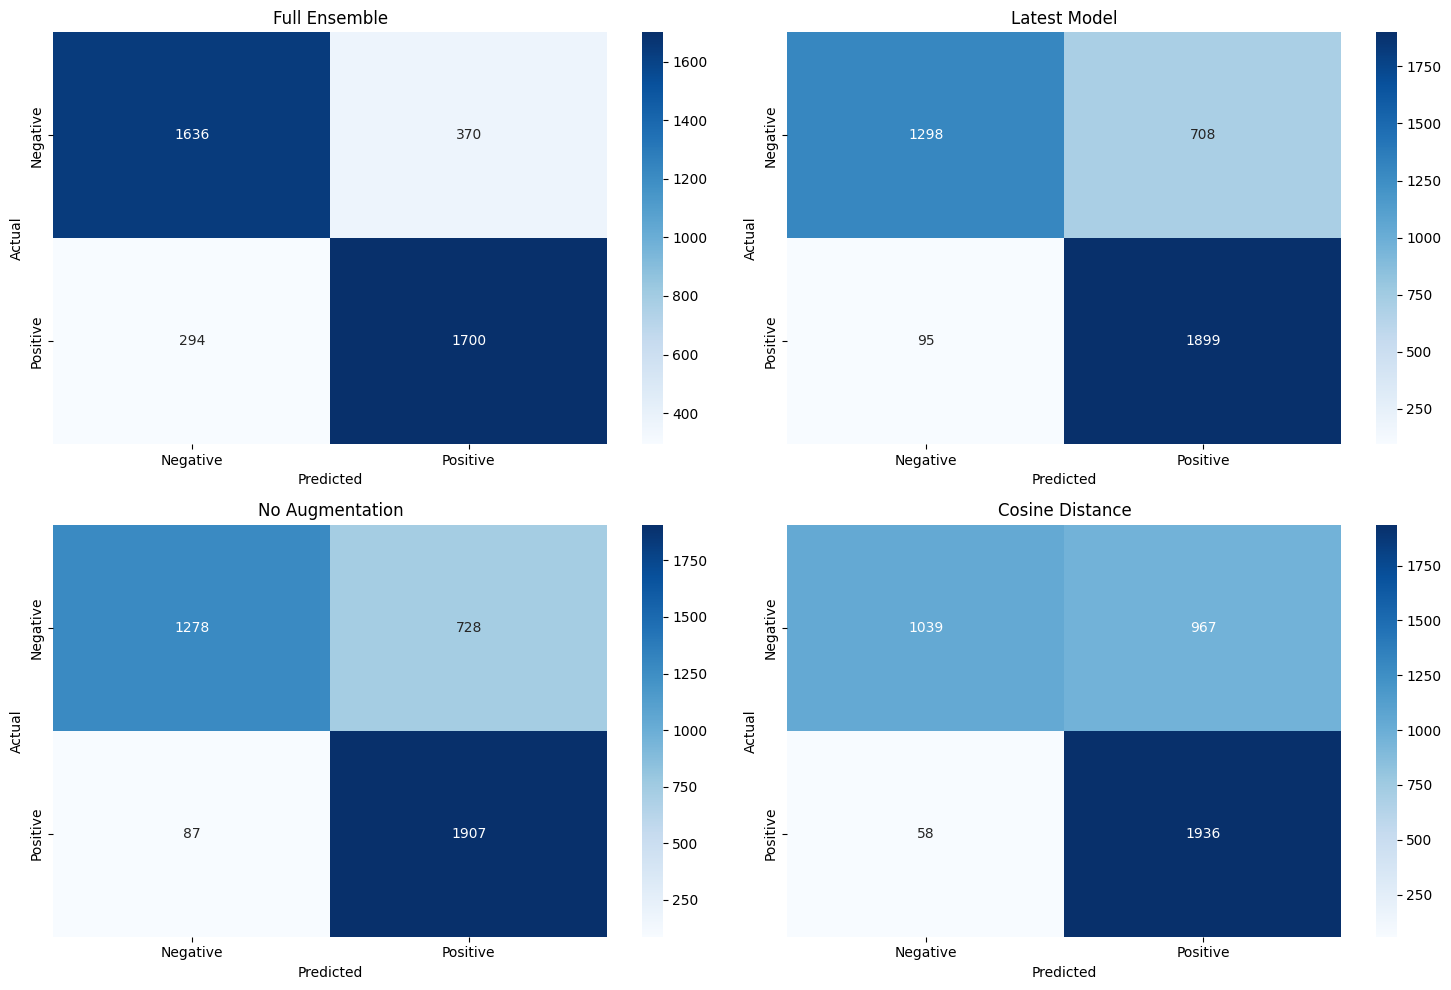

In [31]:
def plot_multiple_confusion_matrices(preds_list, labels_list, titles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i, (preds, labels, title) in enumerate(zip(preds_list, labels_list, titles)):
        threshold = 0.5
        if i != 3:
            binary_preds = (preds > threshold).astype(int)
            cm = confusion_matrix(labels, binary_preds)
        else:
            binary_preds = (preds < threshold_cos_dist).astype(int)
            cm = confusion_matrix(labels, binary_preds)

        row = i // 2
        col = i % 2


        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])

        axes[row, col].set_xlabel('Predicted')
        axes[row, col].set_ylabel('Actual')
        axes[row, col].set_title(title)

    plt.tight_layout()
    plt.show()


preds_list = [all_preds, all_preds_final, all_preds_no_aug, all_preds_cos_dist]
labels_list = [all_labels, all_labels, all_labels, all_labels]
titles = ["Full Ensemble", "Latest Model", "No Augmentation", "Cosine Distance"]

# Plot all confusion matrices in one figure
plot_multiple_confusion_matrices(preds_list, labels_list, titles)